# Observational setup

Here, we set up the observations of the eromapper cluster member galaxies at the AAT.

For each observation (which corresponds to one cluster), we need to produce a single `.fdl` file in the correct format.\
This file needs to include:

- The galaxies to observe (`members`) as the science targets (` = P`)
- The guide stars (` = F`)
- The sky fibres (` = S`),

Where the letter needs to provided with the sources.

## Preparation steps

For each of the clusters, the set up needs to follow the same procedure, which we can adapt from the files by Jacob:

- Initialize the `TargetContainers` with the `cluster_id` and the `ra` and `dec` for the centre of the observation.
- Select and filter the White Dwarfs needed for spectral calibration (within 1 degree) [adopted from `SelectWDs1.py`].
- Select and filter the guide stars (within 1 degree) [adopted from `Guidestargen1.py`].
- Select and filter the sky fibres (within 1 degree) [adopted from `skyfibrefromJacobfile3.py`].
- Select the science targets (in this case the cluster members).

Finally, we plot the distribution for each observation, and generate the `.fdl` files.

### Adopted data structure

For each observational area, we create an instance of a `TargetContainer`, which we successively fill with
information.\
The main code for the operations in detail can be found in `aat_clusters_scripts`.
  
## REQUIREMENTS:

For this script to work, the following packages need to be installed:
- `astropy`
- `astroquery`
- Standard modules like `numpy`, `scipy` (for the matching algorithm of astropy), and `matplotlib`
  
Also, a python version $>$ 3.9 is recommended, but not entirely necessary (with earlier versions, you might need to replace some types in the type hints with imports from the `typing` module, e. g. replace `tuple[str, str]` with `Tuple[str, str]` and include `from typing import Tuple` in the header.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Row
from pathlib import Path
from astropy.coordinates import SkyCoord
import aat_clusters_scripts as acs


ALL_CLUSTERS = Table.read(acs.PATHS.clusters)
CLUSTER_IDS = list(np.unique(ALL_CLUSTERS["mem_match_id"]))
ALL_CLUSTERS.add_index("mem_match_id")

def init_container_from_cluster(cluster: Row) -> acs.TargetContainer:
    cluster_id, ra, dec = cluster[["mem_match_id", "ra_corr", "dec_corr"]]
    return acs.TargetContainer(cluster_id, ra, dec)

TARGET_CONTAINERS = [init_container_from_cluster(cluster) for cluster in ALL_CLUSTERS]
TARGET_CONTAINERS

[TargetContainer(container_id=-2060224498, obs_ra=180.8243662793358, obs_dec=-21.565079896300006, selection_radius=1.0, science_targets=None, white_dwarfs=None, guide_stars=None, sky_fibres=None),
 TargetContainer(container_id=-879663103, obs_ra=168.70913355366255, obs_dec=-12.230408058927948, selection_radius=1.0, science_targets=None, white_dwarfs=None, guide_stars=None, sky_fibres=None),
 TargetContainer(container_id=-1855905442, obs_ra=223.1186759011442, obs_dec=-24.453396496037488, selection_radius=1.0, science_targets=None, white_dwarfs=None, guide_stars=None, sky_fibres=None)]

## Member selection

In this step, we select the cluster members to observe and format the table to have the columns we need.\
We also perform the following filtering:
- We discard all sources with $r\text{\_mag} < 17.5$ as they are too bright.

In [2]:
for target_container in TARGET_CONTAINERS:
    target_container.get_science_targets()

[-2060224498] 184 science targets (cluster members) have been registered.
	count_initial = 197
	count_clean = 197
	count_brightness_cut = 184
[-879663103] 141 science targets (cluster members) have been registered.
	count_initial = 149
	count_clean = 149
	count_brightness_cut = 141
[-1855905442] 71 science targets (cluster members) have been registered.
	count_initial = 145
	count_clean = 145
	count_brightness_cut = 71


## White Dwarf selection

We want to observe some White Dwarfs to calibrate our spectra.

<s>The White Dwarf catalogue has been obtained from the Gaia EDR3 ([download link](https://warwick.ac.uk/fac/sci/physics/research/astro/research/catalogues/gaiaedr3_wd_main.fits.gz)), described Gentile Fusillo et al. 2021 (see [here](https://arxiv.org/pdf/2106.07669.pdf) for the pdf).</s>\
$\implies$ We use `WD_gaia.fits`, the same catalogue as Jacob.

For the selection, we follow the procedure adopted in `SelectWD1.py` with an additional restriction:
- We select all white dwarfs within a radius of `1 deg` of the central ra and dec for each cluster.
- Also, we require `RPmag`, `pmra` und `pmdec` to exist (although this seems to be ok for all sources).

In [3]:
for target_container in TARGET_CONTAINERS:
    target_container.get_white_dwarfs()

[-2060224498] 30 white dwarfs have been registered.
	count_initial = 486641
	count_in_region = 30
	count_clean = 30
	count_faint = 30
[-879663103] 24 white dwarfs have been registered.
	count_initial = 486641
	count_in_region = 24
	count_clean = 24
	count_faint = 24
[-1855905442] 26 white dwarfs have been registered.
	count_initial = 486641
	count_in_region = 28
	count_clean = 28
	count_faint = 26


## Select the guide stars


We follow the procedure in `Guidestargen1.py`:

- We first obtain the clusters via `astroquery` which could also manually be done by performing a coordinate query [on the Simbad site](http://simbad.cds.unistra.fr/simbad/sim-fcoo), but the use of astroquery seems to be more convenient (I have briefly tested it, it yields the same results).\
We adopt a search radius of `1 degree` around the centre of each observation.
- Then, all guide stars without `pmra`, `pmdec` or `rmag` values are removed.
- All sources too dim, too bright, or with a high proper motion are removed, corresponding to the following criteria:
  - $12 < r \text{\_mag} < 14$
  - $pm < 20$, where $pm:=\sqrt{(0.3977 pm_\text{ra})^2+pm_\text{dec}^2}$
- Then, it is made sure that the type of the sources is stellar.
- Finally, the sources are sorted by their r magnitude.

In [4]:
GUIDE_R_MIN = 12
GUIDE_R_MAX = 14
GUIDE_PM_MAX = 20  # ! Jacob has different his values here, talk with Mara
for target_container in TARGET_CONTAINERS:
    target_container.get_guide_stars(GUIDE_R_MIN, GUIDE_R_MAX, GUIDE_PM_MAX)

[-2060224498] 48 guide stars have been registered.
	count_initial = 551
	count_clean = 70
	count_flux_limited = 70
	count_stars_only = 48
[-879663103] 148 guide stars have been registered.
	count_initial = 749
	count_clean = 202
	count_flux_limited = 202
	count_stars_only = 148
[-1855905442] 254 guide stars have been registered.
	count_initial = 600
	count_clean = 286
	count_flux_limited = 286
	count_stars_only = 254


In [5]:
stars = ["*", "HB*", "Ae*", "Em*", "Be*", "BS*",
                 "RG*", "AB*", "C*", "S*", "sg*", "s*r", "s*y", "HS*"]
np.isin(TARGET_CONTAINERS[0].guide_stars["otype"], stars)
TARGET_CONTAINERS[1].guide_stars[["otype", "otypes", "otype_opt"]][:3]
# ! Talk to Mara about differences in selection!

otype,otypes,otype_opt
object,object,object
Star,*|IR,*
Star,*|*,*
Star,*|IR,*


## Select the sky fibres

As a final step, the sky fibre selection is performed.\
We follow the procedure in `skyfibrefromJacobfile3.py`:

- Again, we make sure to select only fibres in a `1 degree` range of the observational centre.
- Then, Jacob showed two approaches:
  1. Select on the `in_sample_100` column
  2. Select 60 random fibres that are more than `5 arcmin` (later also `3 arcmin`) apart from each other.

In [9]:
for target_container in TARGET_CONTAINERS:
    target_container.get_sky_fibres()

[-2060224498] 100 sky fibres have been registered.
	count_initial = 100
	count_in_region = 100
[-879663103] 0 sky fibres have been registered.
	count_initial = 100
	count_in_region = 0
[-1855905442] 0 sky fibres have been registered.
	count_initial = 100
	count_in_region = 0


## Write the Files for the observation

In this step, we write the output .fdl files:

In [28]:
for target_container in TARGET_CONTAINERS[:1]:
    sources = target_container.write_target_file()
sources.write("testfileout.fdl", format="csv", delimiter="\t", overwrite=True, formats={"obj_name": lambda x: x.upper(), "rmag": "%.3f"})

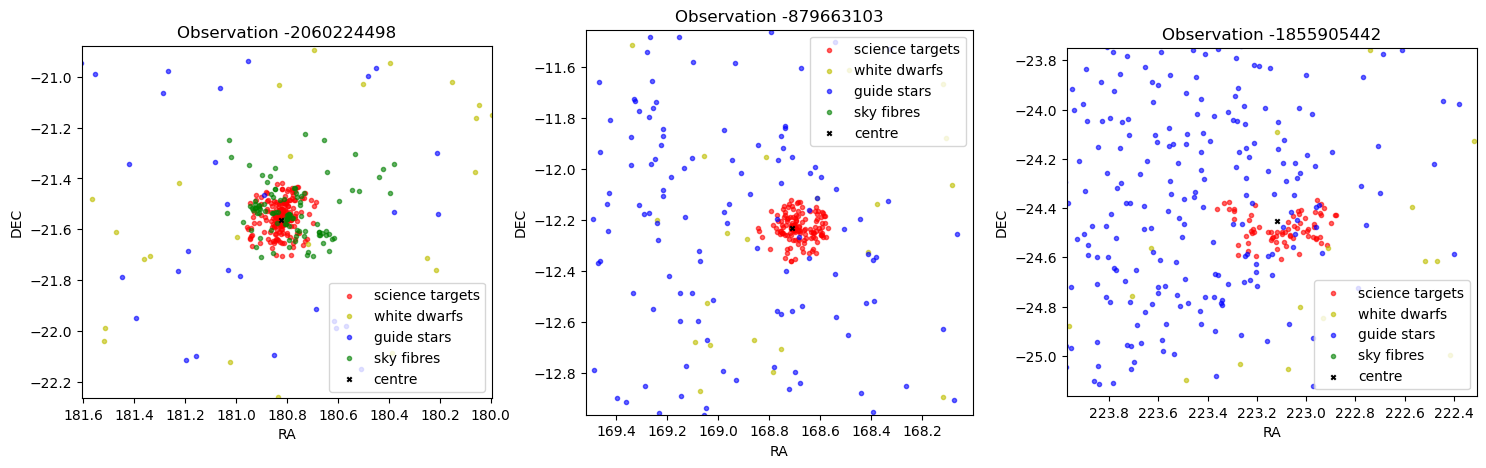

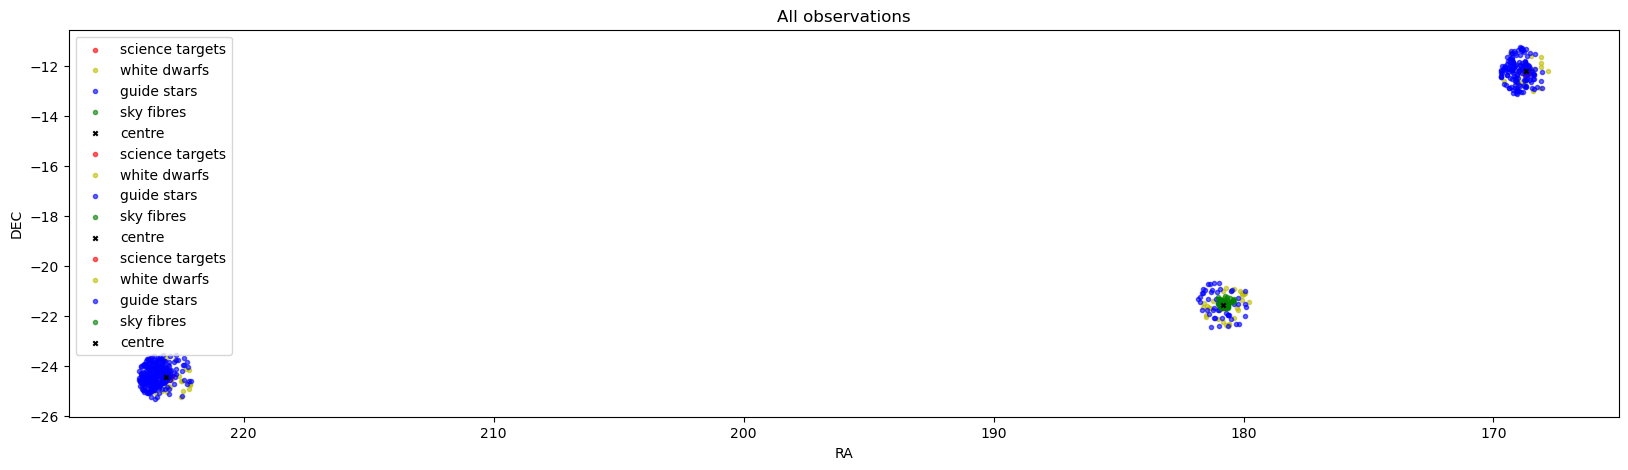

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, container in zip(axes, TARGET_CONTAINERS):
    container.plot_sources_on_ax(ax, alpha=0.6, marker=".")
    ax.margins(-0.1)
fig, ax = plt.subplots(figsize=(20, 20))
for container in TARGET_CONTAINERS:
    container.plot_sources_on_ax(ax, alpha=0.6, marker=".")
    ax.set_title("All observations")

In [3]:
# Copied file header:
LABEL = "eromapper cluster follow-up"
UTDATE = "2023 02 19"
CENTRE = "CENTER_STRING"
FILE_HEADER = f"""
LABEL {LABEL}
UTDATE {UTDATE}
CENTRE {CENTRE}
EQUINOX J2000
WLEN1 6000
PROPER_MOTIONS
"""

In [4]:
COMMENT = """
#                       R. Ascention    Declination             Prog    Proper Motion           Comments
# Name                  hh  mm ss.sss   dd  mm ss.sss                   mag     ID      ra              dec 
# """

In [5]:

fname = Path("./data/observation_setup/target_selection.fdl")
ALL_MEMBERS[relevant_cols].write(fname, format="ascii", overwrite=True)